# DALI plot
This demo compares the true likelihood, the Fisher approximation, and the doublet-DALI approximation for a simple quadratic model, using the derivatives and forecasting tools of <code>DerivKit</code> and <code>ForecastKit</code>. It generates a single plot comparing these three outputs.

In [1]:
import numpy as np
from derivkit.forecast_kit import ForecastKit

import matplotlib.pyplot as plt
myColors = ['C1', 'C2', 'C4']

In [2]:
# Define a model: one observable with a quadratic dependence on one model parameter.
def testModel1d(paramList):
    x = paramList[0]
    obs = 0.4 * x * x
    return np.array([obs])

# Define a function which returns the exact likelihood.
def logLike1dExact(sigma_o, fiducial_x, x):
    delta_o = testModel1d([x]) - testModel1d([fiducial_x])
    logLike = 0
    logLike += -0.5 * (delta_o / sigma_o)**2
    return logLike
    
# Define a function which returns an approximate likelihood using the Fisher and doublet-DALI terms.
def logLike1dApprox(tensors, fiducial_x, x):
    delta_x = x - fiducial_x
    logLike = 0
    if len(tensors)>=1:
        F = tensors[0]
        logLike += -0.5 * F[0][0] * delta_x**2
    if len(tensors)>=3:
        G = tensors[1]
        H = tensors[2]
        logLike += -0.5 * G[0][0][0] * delta_x**3
        logLike += -0.125 * H[0][0][0][0] * delta_x**4
    return logLike

In [3]:
# Define the observables, fiducial parameter values, and covariance matrix.
observables = testModel1d
fiducial_values = [2.11]
covmat = np.array([[2.75]])

In [4]:
# Initialize the forecasting utility using these inputs.
forecaster = ForecastKit(observables, fiducial_values, covmat)

In [5]:
# Create a list of all three tensors: Fisher, doublet-DALI G, and doublet-DALI H.
fisher_matrix = forecaster.get_forecast_tensors(forecast_order = 1)
DALI_G, DALI_H = forecaster.get_forecast_tensors(forecast_order = 2)
tensors = [fisher_matrix, DALI_G, DALI_H]

In [6]:
# Define the fiducial value of the model parameter, x.
fiducial_x = fiducial_values[0]
# Define the 1-\sigma error of the observable, o.
sigma_o = np.sqrt(covmat[0][0])
# Create a 1-dimensional grid of x values over which to compute the likelihoods.
xgrid = np.linspace(-5,5,1000)
# Compute the exact and approximate likelihoods over this grid.
exactLike = [logLike1dExact(sigma_o, fiducial_x, x) for x in xgrid]
fisherLike = [logLike1dApprox([fisher_matrix], fiducial_x, x) for x in xgrid]
doubletDALILike = [logLike1dApprox(tensors, fiducial_x, x) for x in xgrid]

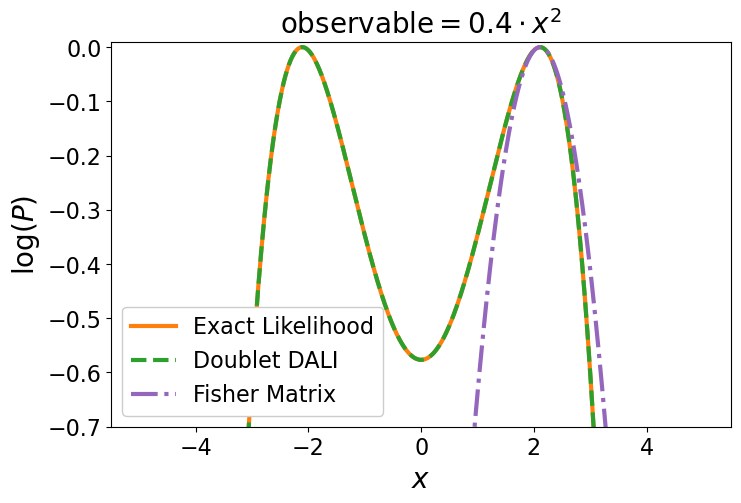

In [7]:
# Plot and compare the three results:
# the exact likelihood, the doublet-DALI approximation, and the Fisher matrix approximation.
plt.figure(figsize=(8,5))
plt.plot(xgrid, exactLike, label='Exact Likelihood', color=myColors[0], linewidth=3)
plt.plot(xgrid, doubletDALILike, label='Doublet DALI', color=myColors[1], linestyle='--', linewidth=3)
plt.plot(xgrid, fisherLike, label='Fisher Matrix', color=myColors[2], linewidth=3, linestyle='-.')
plt.title('$\mathrm{observable}= 0.4 \cdot x^2$', fontsize=20)
plt.xlabel('$x$', fontsize=20)
plt.ylabel('$\mathrm{log}(P)$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(-0.7,0.01)
plt.legend(fontsize=16,framealpha=1.)
plt.savefig("DALI_plot.pdf")